In [11]:
import numpy as np
import os
import pandas as pd
import math
import ROOT as root

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

from eventio.simtel.simtelfile import SimTelFile
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy.interpolate import interp1d

Welcome to JupyROOT 6.16/00


In [2]:
def read_data(filename, n_skip):
   
    wavelength = []
    transmissivity = []

    with open(filename, "r") as file:
        lines = file.readlines()[n_skip:]
        for line in lines:
            words = line.split()
            #print(words[0], ' ; ', words[1])    
            wavelength.append(float(words[0]))
            transmissivity.append(float(words[1]))
                
    return wavelength, transmissivity

In [3]:
nuv_hd_40um = np.loadtxt('/home/andrii/work/terzina/NUV-HD_3x3_40um.dat', dtype=float, comments='#', delimiter = ' ')
nuv_hd_75um = np.loadtxt('/home/andrii/work/terzina/NUV-HD_6x6_75um.out', dtype=float, comments='#', delimiter = ' ')


In [4]:
nuv_hd_75_wavelength = np.append(nuv_hd_75um[:-6,0], nuv_hd_40um[-13:,0])
nuv_hd_75_pde = np.append(nuv_hd_75um[:-6,2], nuv_hd_40um[-13:,2])

In [5]:
f_nuv_hd_40um = interp1d(nuv_hd_40um[:,0], 0.01*nuv_hd_40um[:,2], kind='cubic')
f_nuv_hd_75um = interp1d(nuv_hd_75_wavelength, 0.01*nuv_hd_75_pde, kind='cubic')

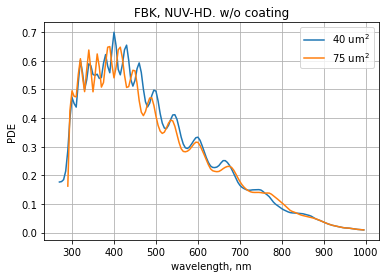

In [6]:
wl_40um = np.arange(nuv_hd_40um[0,0], nuv_hd_40um[-1,0], 5)
wl_75um = np.arange(nuv_hd_75_wavelength[0], nuv_hd_75_wavelength[-1], 5)

plt.plot(wl_40um, f_nuv_hd_40um(wl_40um), label = '40 um$^2$')
plt.plot(wl_75um, f_nuv_hd_75um(wl_75um), label = '75 um$^2$')
plt.grid()
plt.ylabel('PDE')
plt.xlabel('wavelength, nm')
plt.legend()
plt.title('FBK, NUV-HD. w/o coating')
plt.savefig('PDE_FbK.png', dpi = 200)

In [7]:
wl_borofloat, borofloat = read_data('/home/andrii/work/sim_telarray/analysis/spectrums/Borofloat_2ndwdw_SST1M.dat', 4)

In [8]:
f_borofloat = interp1d(wl_borofloat, borofloat, kind='cubic')

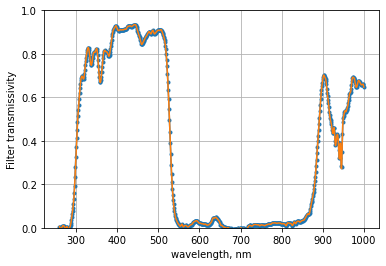

In [115]:
wl_bf = np.arange(wl_borofloat[0], wl_borofloat[-1], 0.05)

plt.plot(wl_borofloat, borofloat, '.-')
plt.plot(wl_bf, f_borofloat(wl_bf))
plt.grid()
plt.ylabel('Filter transmissivity')
plt.xlabel('wavelength, nm')
plt.ylim(0, 1)
plt.savefig('Borofloat_transmissivity.png', dpi = 200)

In [20]:
file = '/home/andrii/work/terzina/signals_Geant4/hist_30km_Impact_Parameter.root'
f1 = root.TFile(file)
h1 = f1.Get("h1_wavelength")

In [66]:
def get_root_hist(file, hist_name):
    
    f1 = root.TFile(file)
    h1 = f1.Get(hist_name)

    bin_center = []
    bin_content = []
    #signal = {}
    
    for ibin in range(0, h1.GetNbinsX(), 1):
        bin_center.append(h1.GetXaxis().GetBinCenter(ibin))
        bin_content.append(h1.GetBinContent(ibin))
        
    signal = {'wavelength' : bin_center, 
              'au' : bin_content}

    return signal
    
    
    

In [131]:
signal_30km = get_root_hist('/home/andrii/work/terzina/signals_Geant4/hist_30km_Impact_Parameter.root', 'h1_wavelength')
signal_25km = get_root_hist('/home/andrii/work/terzina/signals_Geant4/hist_25km_Impact_Parameter.root', 'h1_wavelength')
signal_20km = get_root_hist('/home/andrii/work/terzina/signals_Geant4/hist_20km_Impact_Parameter.root', 'h1_wavelength')
signal_15km = get_root_hist('/home/andrii/work/terzina/signals_Geant4/hist_15km_Impact_Parameter.root', 'h1_wavelength')
signal_10km = get_root_hist('/home/andrii/work/terzina/signals_Geant4/hist_10km_Impact_Parameter.root', 'h1_wavelength')
signal_5km = get_root_hist('/home/andrii/work/terzina/signals_Geant4/hist_5km_Impact_Parameter.root', 'h1_wavelength')
signal_0km = get_root_hist('/home/andrii/work/terzina/signals_Geant4/hist_0km_Impact_Parameter.root', 'h1_wavelength')

In [135]:
plt.plot(signal_30km['wavelength'], signal_30km['au'], label = '30 km')
plt.plot(signal_25km['wavelength'], signal_25km['au'], label = '25 km')
plt.plot(signal_20km['wavelength'], signal_20km['au'], label = '20 km')
plt.plot(signal_15km['wavelength'], signal_15km['au'], label = '15 km')
plt.plot(signal_10km['wavelength'], signal_10km['au'], label = '10 km')
plt.plot(signal_5km['wavelength'], signal_5km['au'], label = '5 km')
plt.plot(signal_0km['wavelength'], signal_0km['au'], label = '0 km')
plt.grid()
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.legend()

In [82]:
signal_30km['au'][10]

0.003384311623967568

In [143]:
def get_integral(signal, sipm_pde, filter_transmitance, wl_start):
    
    signal_integral = np.zeros(len(signal['wavelength']))
    sipm_integral = np.zeros(len(signal['wavelength']))
    sipm_integral_bf = np.zeros(len(signal['wavelength']))
    
    for point, wavelength in enumerate(signal['wavelength']):
        if point > 0:
            signal_integral[point] = signal_integral[point-1] + (signal['wavelength'][point] - signal['wavelength'][point-1])*(signal['au'][point])
        
            if wavelength> wl_start:
                sipm_integral[point] = sipm_integral[point-1] + (signal['wavelength'][point] - signal['wavelength'][point-1])*(signal['au'][point])*(sipm_pde(wavelength))
                sipm_integral_bf[point] = sipm_integral_bf[point-1] + (signal['wavelength'][point] - signal['wavelength'][point-1])*(signal['au'][point])*(sipm_pde(wavelength)*filter_transmitance(wavelength))
        
    return signal_integral, sipm_integral, sipm_integral_bf

In [144]:
total_30km, simp_30km, simp_bf_30km  = get_integral(signal_30km, f_nuv_hd_75um, f_borofloat, wl_75um[0])
total_25km, simp_25km, simp_bf_25km  = get_integral(signal_25km, f_nuv_hd_75um, f_borofloat, wl_75um[0])
total_20km, simp_20km, simp_bf_20km  = get_integral(signal_20km, f_nuv_hd_75um, f_borofloat, wl_75um[0])
total_15km, simp_15km, simp_bf_15km  = get_integral(signal_15km, f_nuv_hd_75um, f_borofloat, wl_75um[0])
total_10km, simp_10km, simp_bf_10km  = get_integral(signal_10km, f_nuv_hd_75um, f_borofloat, wl_75um[0])
total_5km, simp_5km, simp_bf_5km  = get_integral(signal_5km, f_nuv_hd_75um, f_borofloat, wl_75um[0])
total_0km, simp_0km, simp_bf_0km  = get_integral(signal_0km, f_nuv_hd_75um, f_borofloat, wl_75um[0])

In [318]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6), dpi=80)
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(signal_30km['wavelength'], signal_30km['au'])
axs[0].grid()
axs[0].set_ylabel('signal, a.u.')
axs[0].set_title('NUV-HD 75 um$^2$: 30 km impact parameter')

axs[1].plot(signal_30km['wavelength'], simp_30km, label = 'SiPM')
axs[1].plot(signal_30km['wavelength'], simp_bf_30km, label = 'SiPM + Filter')
axs[1].set_ylabel('$\int$ Signal ($\lambda$) d$\lambda$')
axs[1].legend()
axs[1].grid()

axs[2].plot(signal_30km['wavelength'], 100*simp_bf_30km/simp_30km)
axs[2].grid()
axs[2].set_ylabel('Filter efficiency, %')
axs[2].set_xlabel('wavelength, nm')
plt.savefig('results_30km.png', dpi = 200)
plt.show()

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


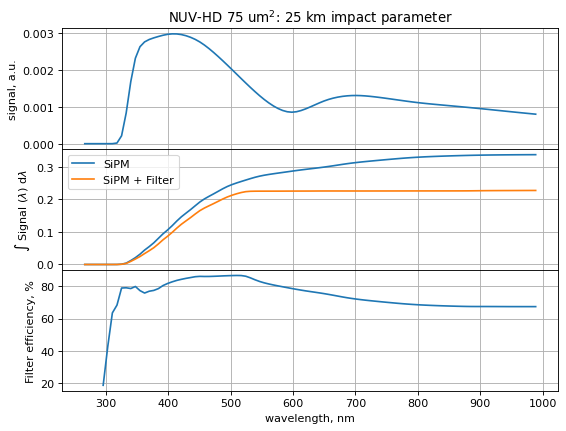

In [317]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6), dpi=80)
fig.subplots_adjust(hspace=0)

axs[0].plot(signal_25km['wavelength'], signal_25km['au'])
axs[0].grid()
axs[0].set_ylabel('signal, a.u.')
axs[0].set_title('NUV-HD 75 um$^2$: 25 km impact parameter')

axs[1].plot(signal_25km['wavelength'], simp_25km, label = 'SiPM')
axs[1].plot(signal_25km['wavelength'], simp_bf_25km, label = 'SiPM + Filter')
axs[1].set_ylabel('$\int$ Signal ($\lambda$) d$\lambda$')
axs[1].legend()
axs[1].grid()

axs[2].plot(signal_25km['wavelength'], 100*simp_bf_25km/simp_25km)
axs[2].grid()
axs[2].set_ylabel('Filter efficiency, %')
axs[2].set_xlabel('wavelength, nm')
plt.savefig('results_25km.png', dpi = 200)

plt.show()

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


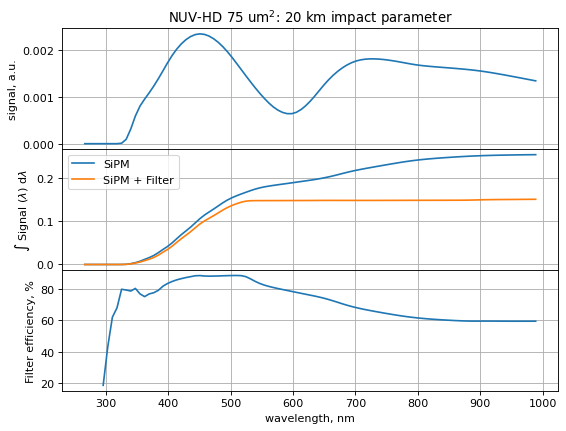

In [316]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6), dpi=80)
fig.subplots_adjust(hspace=0)

axs[0].plot(signal_20km['wavelength'], signal_20km['au'])
axs[0].grid()
axs[0].set_ylabel('signal, a.u.')
axs[0].set_title('NUV-HD 75 um$^2$: 20 km impact parameter')

axs[1].plot(signal_20km['wavelength'], simp_20km, label = 'SiPM')
axs[1].plot(signal_20km['wavelength'], simp_bf_20km, label = 'SiPM + Filter')
axs[1].set_ylabel('$\int$ Signal ($\lambda$) d$\lambda$')
axs[1].legend()
axs[1].grid()

axs[2].plot(signal_20km['wavelength'], 100*simp_bf_20km/simp_20km)
axs[2].grid()
axs[2].set_ylabel('Filter efficiency, %')
axs[2].set_xlabel('wavelength, nm')
plt.savefig('results_20km.png', dpi = 200)
plt.show()

In [315]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6), dpi=80)
fig.subplots_adjust(hspace=0)

axs[0].plot(signal_15km['wavelength'], signal_15km['au'])
axs[0].grid()
axs[0].set_ylabel('signal, a.u.')
axs[0].set_title('NUV-HD 75 um$^2$: 15 km impact parameter')

axs[1].plot(signal_15km['wavelength'], simp_15km, label = 'SiPM')
axs[1].plot(signal_15km['wavelength'], simp_bf_15km, label = 'SiPM + Filter')
axs[1].set_ylabel('$\int$ Signal ($\lambda$) d$\lambda$')
axs[1].legend()
axs[1].grid()

axs[2].plot(signal_15km['wavelength'], 100*simp_bf_15km/simp_15km)
axs[2].grid()
axs[2].set_ylabel('Filter efficiency, %')
axs[2].set_xlabel('wavelength, nm')
plt.savefig('results_15km.png', dpi = 200)
plt.show()

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


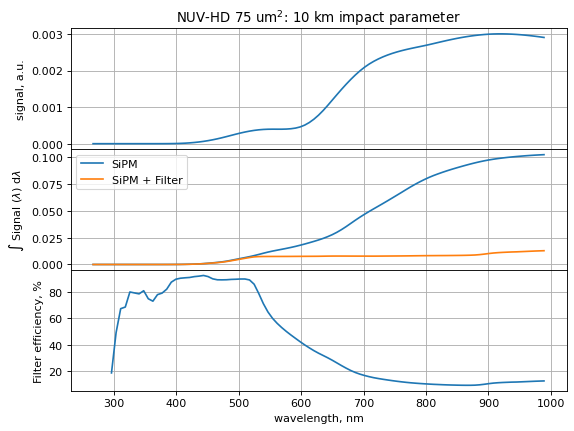

In [314]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6), dpi=80)
fig.subplots_adjust(hspace=0)

axs[0].plot(signal_10km['wavelength'], signal_10km['au'])
axs[0].grid()
axs[0].set_ylabel('signal, a.u.')
axs[0].set_title('NUV-HD 75 um$^2$: 10 km impact parameter')

axs[1].plot(signal_10km['wavelength'], simp_10km, label = 'SiPM')
axs[1].plot(signal_10km['wavelength'], simp_bf_10km, label = 'SiPM + Filter')
axs[1].set_ylabel('$\int$ Signal ($\lambda$) d$\lambda$')
axs[1].legend()
axs[1].grid()

axs[2].plot(signal_10km['wavelength'], 100*simp_bf_10km/simp_10km)
axs[2].grid()
axs[2].set_ylabel('Filter efficiency, %')
axs[2].set_xlabel('wavelength, nm')
plt.savefig('results_10km.png', dpi = 200)
plt.show()

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


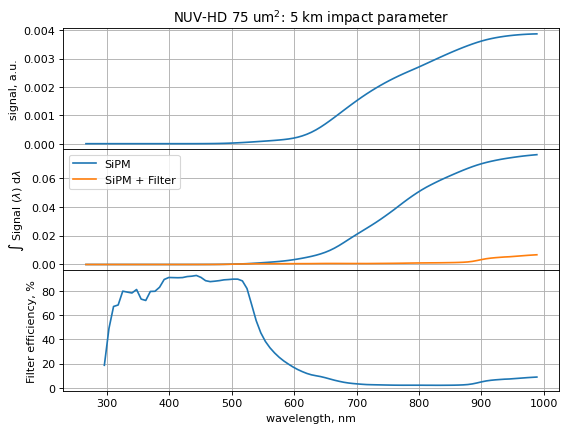

In [313]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6), dpi=80)
fig.subplots_adjust(hspace=0)

axs[0].plot(signal_5km['wavelength'], signal_5km['au'])
axs[0].grid()
axs[0].set_ylabel('signal, a.u.')
axs[0].set_title('NUV-HD 75 um$^2$: 5 km impact parameter')

axs[1].plot(signal_5km['wavelength'], simp_5km, label = 'SiPM')
axs[1].plot(signal_5km['wavelength'], simp_bf_5km, label = 'SiPM + Filter')
axs[1].set_ylabel('$\int$ Signal ($\lambda$) d$\lambda$')
axs[1].legend()
axs[1].grid()

axs[2].plot(signal_5km['wavelength'], 100*simp_bf_5km/simp_5km)
axs[2].grid()
axs[2].set_ylabel('Filter efficiency, %')
axs[2].set_xlabel('wavelength, nm')
plt.savefig('results_5km.png', dpi = 200)
plt.show()

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


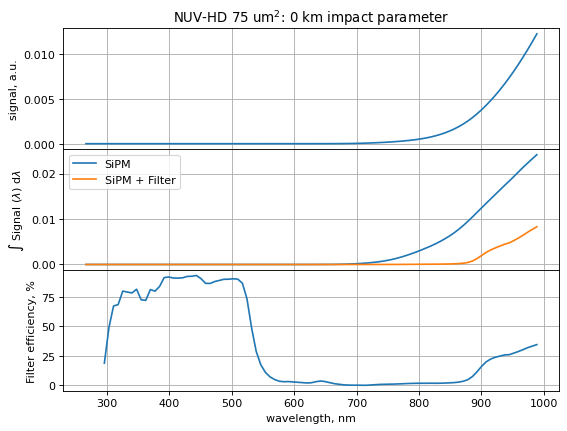

In [312]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6), dpi=80)
fig.subplots_adjust(hspace=0)

axs[0].plot(signal_0km['wavelength'], signal_0km['au'])
axs[0].grid()
axs[0].set_ylabel('signal, a.u.')
axs[0].set_title('NUV-HD 75 um$^2$: 0 km impact parameter')

axs[1].plot(signal_0km['wavelength'], simp_0km, label = 'SiPM')
axs[1].plot(signal_0km['wavelength'], simp_bf_0km, label = 'SiPM + Filter')
axs[1].set_ylabel('$\int$ Signal ($\lambda$) d$\lambda$')
axs[1].legend()
axs[1].grid()

axs[2].plot(signal_0km['wavelength'], 100*simp_bf_0km/simp_0km)
axs[2].grid()
axs[2].set_ylabel('Filter efficiency, %')
axs[2].set_xlabel('wavelength, nm')
plt.savefig('results_0km.png', dpi = 200)
plt.show()

In [252]:
ratio = np.array([simp_bf_0km[-1]/simp_0km[-1], simp_bf_5km[-1]/simp_5km[-1], simp_bf_10km[-1]/simp_10km[-1], simp_bf_15km[-1]/simp_15km[-1], simp_bf_20km[-1]/simp_20km[-1], simp_bf_25km[-1]/simp_25km[-1], simp_bf_30km[-1]/simp_30km[-1]])
signal = np.array([simp_0km[-1], simp_5km[-1], simp_10km[-1], simp_15km[-1], simp_20km[-1], simp_25km[-1], simp_30km[-1]])
signal_filter = np.array([simp_bf_0km[-1], simp_bf_5km[-1], simp_bf_10km[-1], simp_bf_15km[-1], simp_bf_20km[-1], simp_bf_25km[-1], simp_bf_30km[-1]])
impact_km = np.array([0, 5, 10, 15, 20, 25, 30])

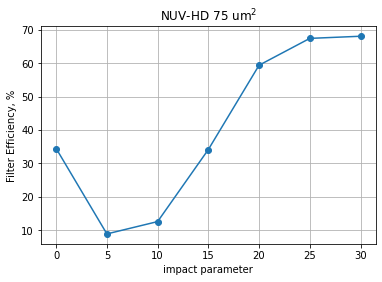

In [319]:
plt.plot(impact_km, 100*ratio, 'o-')
plt.grid()
plt.title('NUV-HD 75 um$^2$')
plt.ylabel('Filter Efficiency, %')
plt.xlabel('impact parameter')
plt.savefig('filter_efficiency.png', dpi = 200)

In [284]:
plt.plot(impact_km, signal, 'o-', label = 'SiPM')
plt.plot(impact_km, signal_filter, 'o-', label = 'SiPM + Filter')
plt.grid()
plt.title('NUV-HD 75 um$^2$')
plt.ylabel('$\int$ Signal ($\lambda$) d$\lambda$')
plt.xlabel('impact parameter, km')
plt.legend()
plt.savefig('Signal_integral.png', dpi = 200)

In [239]:
impact

array([ 0,  5, 10, 15, 20, 25, 30])

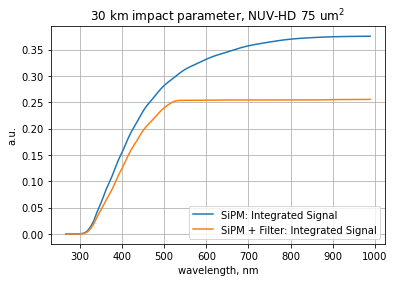

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


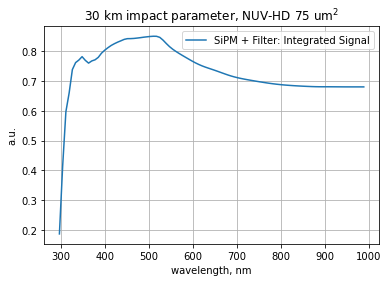

In [161]:
#plt.plot(signal_30km['wavelength'], total_30km, label = 'Integrated Signal')
plt.plot(signal_30km['wavelength'], simp_30km, label = 'SiPM: Integrated Signal')
plt.plot(signal_30km['wavelength'], simp_bf_30km, label = 'SiPM + Filter: Integrated Signal')
plt.legend()
plt.title('30 km impact parameter, NUV-HD 75 um$^2$')
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.grid()
plt.show()

#plt.plot(signal_30km['wavelength'], simp_30km, label = 'SiPM: Integrated Signal')
plt.plot(signal_30km['wavelength'], simp_bf_30km/simp_30km, label = 'SiPM + Filter: Integrated Signal')
plt.legend()
plt.title('30 km impact parameter, NUV-HD 75 um$^2$')
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.grid()

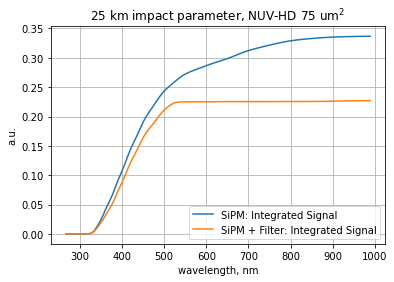

In [151]:
#plt.plot(signal_25km['wavelength'], total_25km, label = 'Integrated Signal')
plt.plot(signal_25km['wavelength'], simp_25km, label = 'SiPM: Integrated Signal')
plt.plot(signal_25km['wavelength'], simp_bf_25km, label = 'SiPM + Filter: Integrated Signal')
plt.legend()
plt.title('25 km impact parameter, NUV-HD 75 um$^2$')
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.grid()

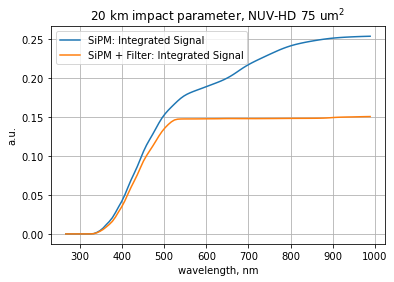

In [152]:
#plt.plot(signal_20km['wavelength'], total_20km, label = 'Integrated Signal')
plt.plot(signal_20km['wavelength'], simp_20km, label = 'SiPM: Integrated Signal')
plt.plot(signal_20km['wavelength'], simp_bf_20km, label = 'SiPM + Filter: Integrated Signal')
plt.legend()
plt.title('20 km impact parameter, NUV-HD 75 um$^2$')
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.grid()

In [153]:
#plt.plot(signal_15km['wavelength'], total_15km, label = 'Integrated Signal')
plt.plot(signal_15km['wavelength'], simp_15km, label = 'SiPM: Integrated Signal')
plt.plot(signal_15km['wavelength'], simp_bf_15km, label = 'SiPM + Filter: Integrated Signal')
plt.legend()
plt.title('15 km impact parameter, NUV-HD 75 um$^2$')
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.grid()

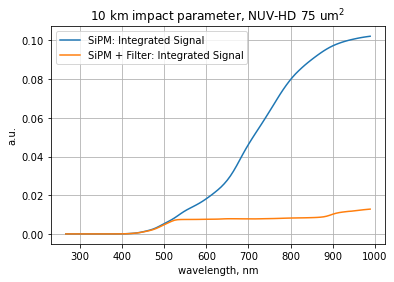

In [159]:
#plt.plot(signal_10km['wavelength'], total_10km, label = 'Integrated Signal')
plt.plot(signal_10km['wavelength'], simp_10km, label = 'SiPM: Integrated Signal')
plt.plot(signal_10km['wavelength'], simp_bf_10km, label = 'SiPM + Filter: Integrated Signal')
plt.legend()
plt.title('10 km impact parameter, NUV-HD 75 um$^2$')
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.grid()

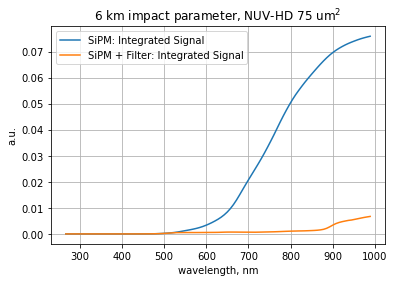

In [158]:
#plt.plot(signal_5km['wavelength'], total_5km, label = 'Integrated Signal')
plt.plot(signal_5km['wavelength'], simp_5km, label = 'SiPM: Integrated Signal')
plt.plot(signal_5km['wavelength'], simp_bf_5km, label = 'SiPM + Filter: Integrated Signal')
plt.legend()
plt.title('6 km impact parameter, NUV-HD 75 um$^2$')
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.grid()

In [157]:
#plt.plot(signal_0km['wavelength'], total_0km, label = 'Integrated Signal')
plt.plot(signal_0km['wavelength'], simp_0km, label = 'SiPM: Integrated Signal')
plt.plot(signal_0km['wavelength'], simp_bf_0km, label = 'SiPM + Filter: Integrated Signal')
plt.legend()
plt.title('0 km impact parameter, NUV-HD 75 um$^2$')
plt.ylabel('a.u.')
plt.xlabel('wavelength, nm')
plt.grid()